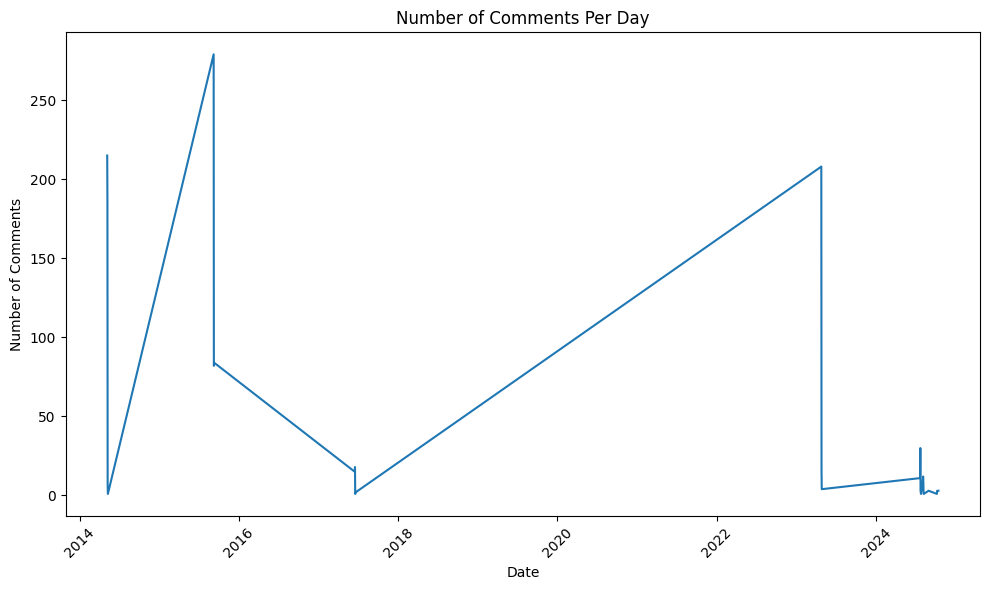

In [43]:
# Import necessary libraries
import praw
import pandas as pd
from textblob import TextBlob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Reddit API credentials
reddit = praw.Reddit(
    client_id="tQT8gjNPAUsapQ65e1Ft0Q",
    client_secret="bMA87kb-r0ju1LQehUed4Zzc68JfXg",
    user_agent="python:reddit.sentiment.analysis:v1.0 (by u/ThomasWaugh1702)"
)

def fetch_topic_comments(topic, subreddit_name="all", post_limit=10):
    comments = []
    subreddit = reddit.subreddit(subreddit_name)

    for post in subreddit.search(topic, limit=post_limit):
        post.comments.replace_more(limit=0)
        for comment in post.comments.list():
            comments.append(comment)

    return comments

# Clean and fetch comments related to antimicrobial resistance
topic_comments = fetch_topic_comments("antimicrobial resistance", subreddit_name="science", post_limit=10)

# Perform sentiment analysis and capture timestamps
def analyze_sentiment_with_time(comments):
    sentiment_data = []
    for comment in comments:
        try:
            timestamp = comment.created_utc
            timestamp = datetime.utcfromtimestamp(timestamp)

            # Perform sentiment analysis
            blob = TextBlob(comment.body)
            sentiment_data.append({
                "comment": comment.body,
                "polarity": blob.sentiment.polarity,
                "subjectivity": blob.sentiment.subjectivity,
                "timestamp": timestamp
            })
        except Exception as e:
            continue
    
    return pd.DataFrame(sentiment_data)

# Analyze sentiment and convert to DataFrame
sentiment_df = analyze_sentiment_with_time(topic_comments)

# Convert timestamp to datetime if it isn't already
sentiment_df['timestamp'] = pd.to_datetime(sentiment_df['timestamp'])

# Group by day and count the number of comments
comments_by_day = sentiment_df.groupby(sentiment_df['timestamp'].dt.date).size()

# Plotting the time series of comments per day
plt.figure(figsize=(10, 6))
sns.lineplot(x=comments_by_day.index, y=comments_by_day.values)
plt.title("Number of Comments Per Day")
plt.xlabel("Date")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
